In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import srt
import torchaudio
from sklearn.model_selection import train_test_split
from torchaudio.transforms import Resample
from tqdm.notebook import tqdm

from data_analysis_common_utils import summarize_duration, summarize_sentences

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
target_sr = 16000
studio_data_dir = Path(r"C:\Users\robert\Desktop\datasets\aurimas_studio_data")
srt_dir = studio_data_dir / "srts"
wav_dir = studio_data_dir / "wavs"
output_clips_dir = Path("../files/studio_clips")
output_clips_dir.mkdir(exist_ok=True, parents=True)

In [3]:
rows = []

# Process each SRT file
for srt_file in tqdm(list(srt_dir.glob("*.srt"))):
    base_name = srt_file.stem
    wav_file = wav_dir / f"{base_name}.wav"

    if not wav_file.exists():
        print(f"Skipping {base_name}, WAV not found.")
        continue

    with open(srt_file, "r", encoding="utf-8") as f:
        subs = list(srt.parse(f.read()))

    waveform, sr = torchaudio.load(wav_file)

    # Resample if needed
    if sr != target_sr:
        resampler = Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
        sr = target_sr

    # Process each subtitle
    for idx, sub in enumerate(subs, start=1):
        start_sample = int(sub.start.total_seconds() * sr)
        end_sample = int(sub.end.total_seconds() * sr)

        clip_audio = waveform[:, start_sample:end_sample]
        clip_filename = f"{base_name}_{idx:04d}.wav"
        clip_path = output_clips_dir / clip_filename
        torchaudio.save(clip_path.as_posix(), clip_audio, sr)
        duration = clip_audio.shape[1] / sr

        text = sub.content.strip()

        # Entries with * denote some error the data and should be excluded
        if "*" not in text:
            rows.append({
                "path": str(clip_path.relative_to("..").as_posix()),
                "sentence": sub.content.strip(),
                "duration[s]": duration
            })

df = pd.DataFrame(rows)
print(df.info())
df.head()

  0%|          | 0/12 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5265 entries, 0 to 5264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   path         5265 non-null   object 
 1   sentence     5265 non-null   object 
 2   duration[s]  5265 non-null   float64
dtypes: float64(1), object(2)
memory usage: 123.5+ KB
None


,path,sentence,duration[s]
0,files/studio_clips/01-SKYRIUS_0001.wav,Pìrmas skỹrius.,0.766
1,files/studio_clips/01-SKYRIUS_0002.wav,Mẽs stóvime devynì kilomètrai nuõ frònto.,2.198
2,files/studio_clips/01-SKYRIUS_0003.wav,Vãkar mùs pàkeitė.,1.105
3,files/studio_clips/01-SKYRIUS_0004.wav,Mū́sų pilvaĩ nèt brãška nuõ pupẽlių sù j...,5.960
4,files/studio_clips/01-SKYRIUS_0005.wav,Nèt ir̃ vakariẽnei kiekvíenas galė́jo pasii...,9.986


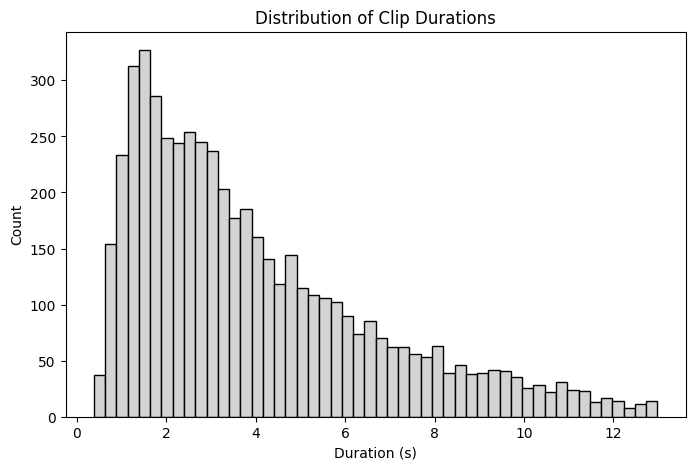

Summary statistics for duration[s]:
count    5265.000000
mean        4.003609
std         2.720402
min         0.381000
5%          0.972400
25%         1.865000
50%         3.215000
75%         5.458000
95%         9.713000
max        12.985000
Name: duration[s], dtype: float64


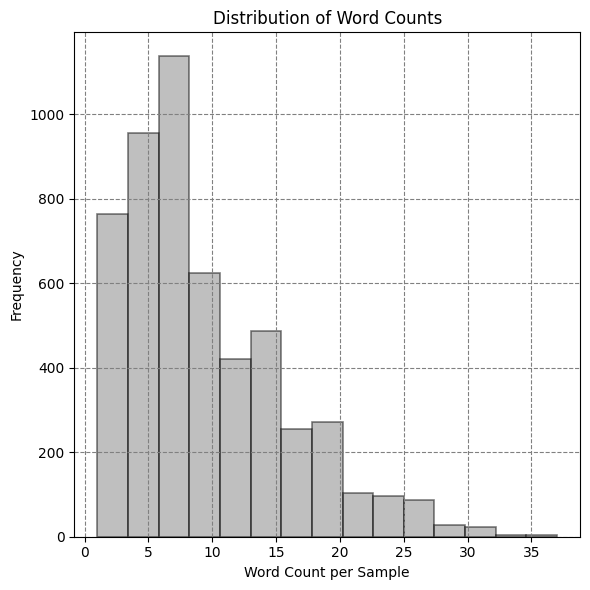


    Word statistics (Per Text):
        Total:       49434
        Unique:      13153
        Mean:         9.39
        STD:          6.18
        Median:       8.00
        Min:             1
        Max:            37
    


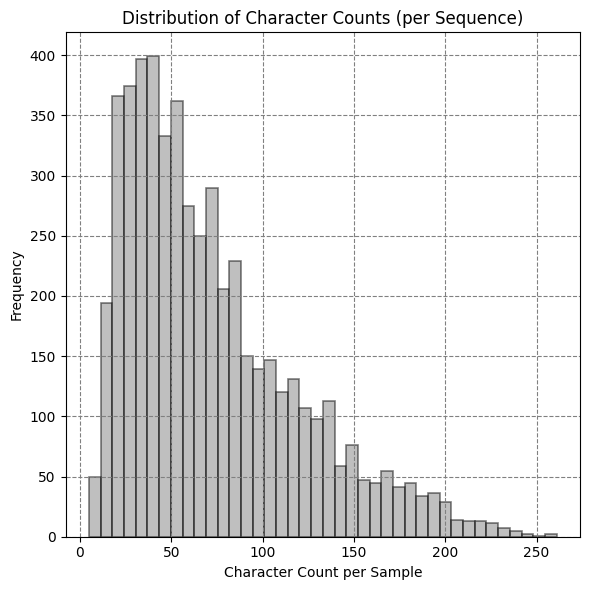


    Character statistics (Per Text):
        Total:      379977
        Mean:        72.17
        STD:         47.16
        Median:      60.00
        Min:             5
        Max:           261
    


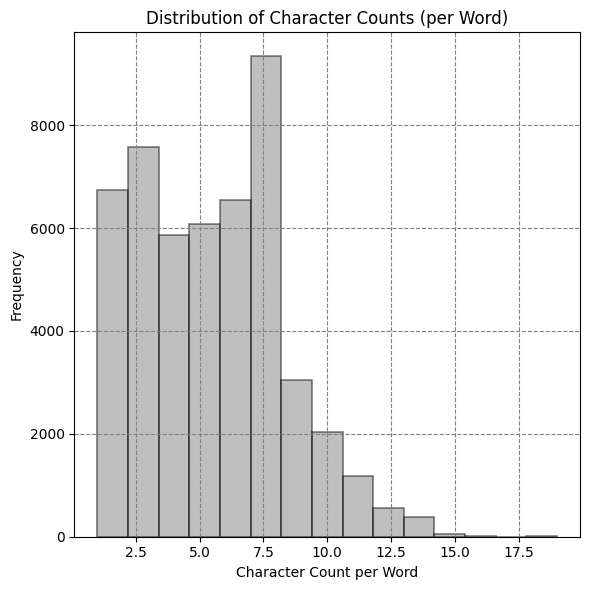


    Character statistics (Per Word):
        Total:      271948
        Mean:         5.50
        STD:          2.71
        Median:       5.00
        Min:             1
        Max:            19
    


In [4]:
# FULL DATASET
summarize_duration(df)
summarize_sentences(df)

In [5]:
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 4738
Test size: 527


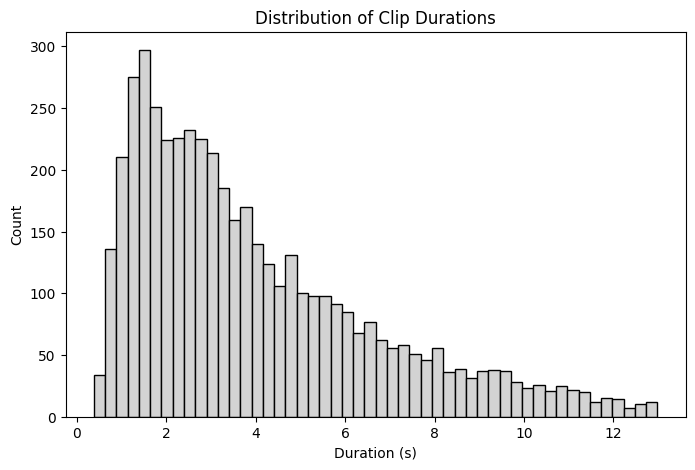

Summary statistics for duration[s]:
count    4738.000000
mean        3.998842
std         2.711405
min         0.381000
5%          0.979550
25%         1.877750
50%         3.209500
75%         5.459500
95%         9.691150
max        12.985000
Name: duration[s], dtype: float64


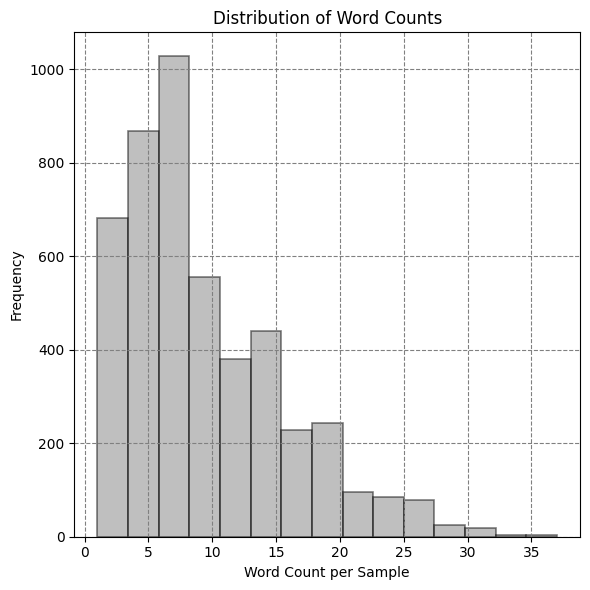


    Word statistics (Per Text):
        Total:       44457
        Unique:      12181
        Mean:         9.38
        STD:          6.17
        Median:       8.00
        Min:             1
        Max:            37
    


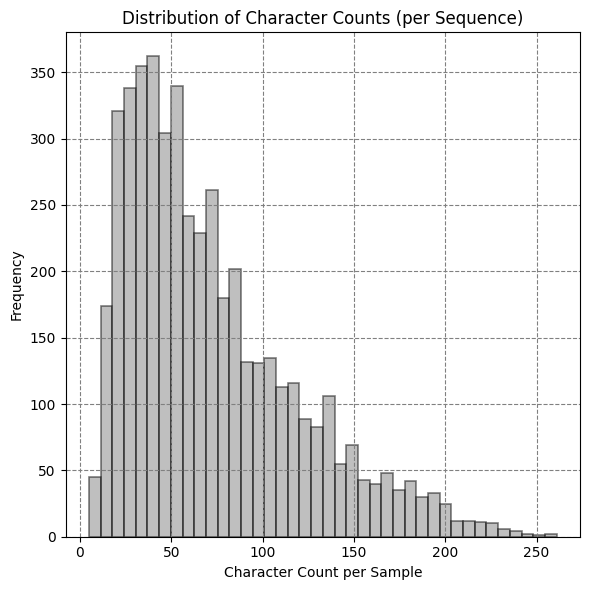


    Character statistics (Per Text):
        Total:      341526
        Mean:        72.08
        STD:         47.01
        Median:      60.00
        Min:             5
        Max:           261
    


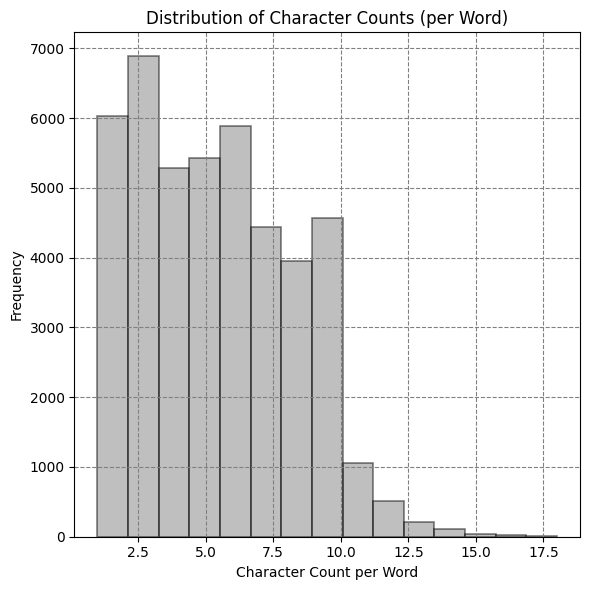


    Character statistics (Per Word):
        Total:      244412
        Mean:         5.50
        STD:          2.71
        Median:       5.00
        Min:             1
        Max:            18
    


In [6]:
# TRAINING SET
summarize_duration(train_df)
summarize_sentences(train_df)

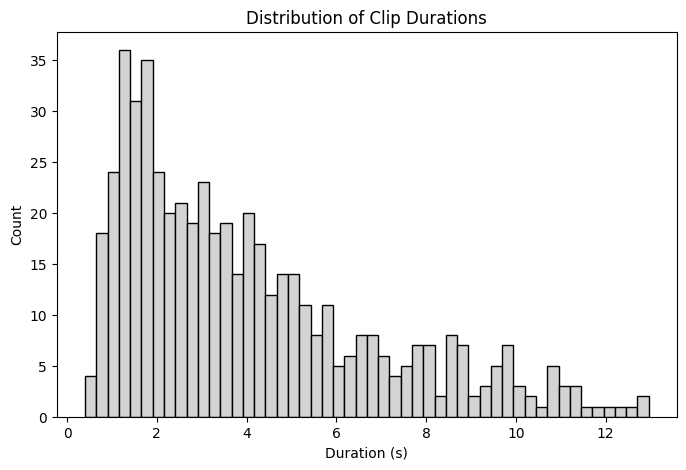

Summary statistics for duration[s]:
count    527.000000
mean       4.046472
std        2.802272
min        0.402000
5%         0.962400
25%        1.791000
50%        3.268000
75%        5.445500
95%        9.776200
max       12.961000
Name: duration[s], dtype: float64


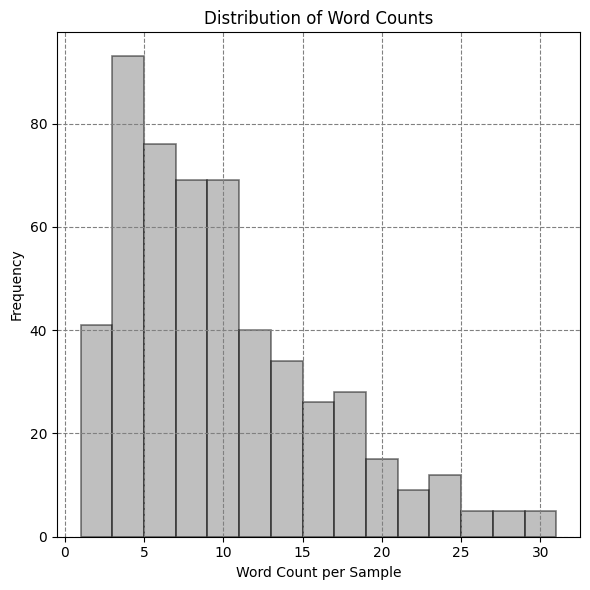


    Word statistics (Per Text):
        Total:        4977
        Unique:       2506
        Mean:         9.44
        STD:          6.27
        Median:       8.00
        Min:             1
        Max:            31
    


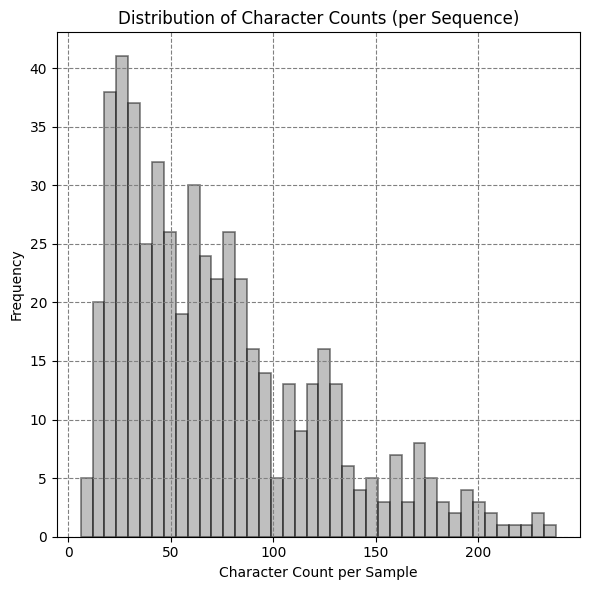


    Character statistics (Per Text):
        Total:       38451
        Mean:        72.96
        STD:         48.50
        Median:      61.00
        Min:             6
        Max:           238
    


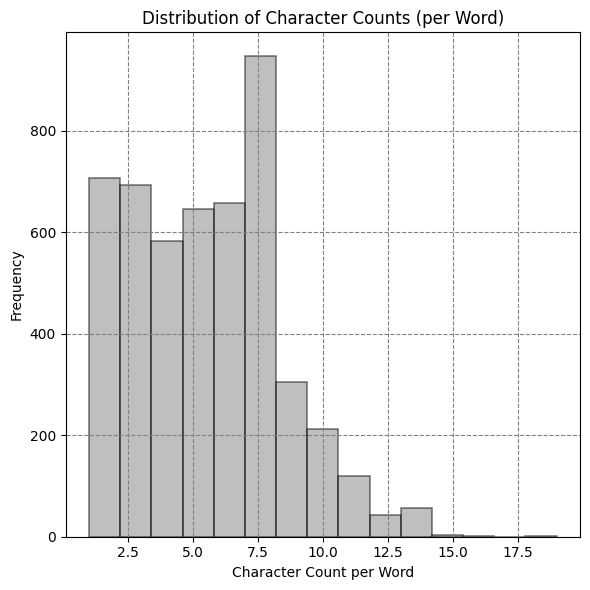


    Character statistics (Per Word):
        Total:       27536
        Mean:         5.53
        STD:          2.73
        Median:       5.00
        Min:             1
        Max:            19
    


In [7]:
# TESTING SET
summarize_duration(test_df)
summarize_sentences(test_df)

In [8]:
def save_filelist(_df: pd.DataFrame, out_path: str):
    df.to_csv(
        out_path,
        sep="|",
        index=False,
        header=False,
        columns=["path", "sentence"]
    )
    print(f"Saved filelist to {out_path}")


save_filelist(train_df, "../files/studio_stress_train.txt")
save_filelist(test_df, "../files/studio_stress_test.txt")

Saved filelist to ../files/studio_train.txt
Saved filelist to ../files/studio_test.txt
